# Mountain Car
### Pierpaolo Spaziani - 0316331

In [23]:
import gym
import numpy as np
import imageio
import random
import math
import matplotlib.pyplot as plt

In [24]:
# In the gym library there is a deprecation about NumPy
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="gym.utils.passive_env_checker")

### Parameters

In [58]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPSILON = 1
# EPSILON_DECAY: 0 for linear - 1 for exponential

EPISODES = 10000

DISCRETE_SIZE = 20

RENDER = False
SHOW_EVERY = 2

In [41]:
if RENDER:
    env = gym.make("MountainCar-v0", render_mode="rgb_array_list")
else:
    env = gym.make("MountainCar-v0")

### Discretization
In the presence of *continuous states* it is convenient to **discretize** for several reasons:
- Limit the state space
- Memory management
- Faster training
- Generalization

In [42]:
chunk_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_SIZE

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low) / chunk_size
    return tuple(discrete_state.astype(int))

### ε-Greedy

Implementation of the **ε-Greedy** policy for *exploration-exploitation trade-off* with 2 types of decay:
- *linear decay*
- *exponential decay*

In [43]:
def epsilon_greedy(epsilon):
    if random.uniform(0, 1) < epsilon:
        # takes a random action
        return random.choice(range(env.action_space.n))
    else:
        # takes the "best" action
        return -1

epsilon_hystory = []

def linear_decay(epsilon):
    decay_rate = EPSILON / EPISODES
    epsilon = epsilon - decay_rate
    epsilon_hystory.append(epsilon)
    return max(0, epsilon)

def exponential_decay(episode):
    alpha = -math.log(0.01) / (EPISODES)
    epsilon = EPSILON * math.exp(-alpha * episode)
    epsilon_hystory.append(epsilon)
    return max(0, epsilon)


### Q-Learning

Implementation of the solution based on **Q-Learning**:

In [44]:
q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))

def q_learning(EPSILON_DECAY):
    epsilon = EPSILON
    howmany = 0
    q_learning_list = []
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        env.reset()
    
        if (RENDER and episode % SHOW_EVERY == 0):
            render = True
        else:
            render = False
    
        discrete_state = get_discrete_state(env.state)

        if EPSILON_DECAY == 0:
            epsilon = linear_decay(epsilon)
        else:
            epsilon = exponential_decay(episode)
        
        done = False
        while not done:
            
            # select an action following the epsilon-greedy policy
            action = epsilon_greedy(epsilon)
            if action < 0:
                action = np.argmax(q_table[discrete_state])
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)
        
            done = terminated or truncated
            if not done:
                max_future_q = np.max(q_table[new_discrete_state])
                current_q = q_table[discrete_state + (action, )]
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
                q_table[discrete_state + (action, )] = new_q
            elif terminated:
                howmany = howmany + 1
                #print(f"Congratulation! We reached to the goal! Episode: {episode}")
                #q_table[discrete_state + (action, )] = 0 # ----------------------------------------> SECONDO ME QUESTO VA TOLTO
    
            discrete_state = new_discrete_state
        q_learning_list.append(howmany)
            
        if render:
            imageio.mimsave(f'./gifs/{episode}.gif', env.render(), fps=30)
    
    env.close()
    return q_learning_list

In [45]:
q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))

def SARSA(EPSILON_DECAY):
    epsilon = EPSILON
    howmany = 0
    sarsa_list = []
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        env.reset()
    
        if (RENDER and episode % SHOW_EVERY == 0):
            render = True
        else:
            render = False
    
        discrete_state = get_discrete_state(env.state)

        if EPSILON_DECAY == 0:
            epsilon = linear_decay(epsilon)
        else:
            epsilon = exponential_decay(episode)
        
        # select an action following the epsilon-greedy policy
        action = epsilon_greedy(epsilon)
        if action < 0:
            action = np.argmax(q_table[discrete_state])
        
        done = False
        while not done:
                
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)

            # Select a new action following the epsilon-greedy policy
            new_action = epsilon_greedy(epsilon)
            if new_action < 0:
                new_action = np.argmax(q_table[new_discrete_state])
        
            done = terminated or truncated
            if not done:                
                new_q = q_table[new_discrete_state + (new_action, )]
                current_q = q_table[discrete_state + (action, )]
                updated_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * new_q)
                q_table[discrete_state + (action, )] = updated_q
                
            elif terminated:
                howmany = howmany + 1
                #print(f"Congratulation! We reached to the goal! Episode: {episode}")
    
            discrete_state = new_discrete_state
            action = new_action
        sarsa_list.append(howmany)
            
        if render:
            imageio.mimsave(f'./gifs/{episode}.gif', env.render(), fps=30)
    
    env.close()
    return sarsa_list

In [59]:
q_learning_list = q_learning(1)
print("Ci sono stati", q_learning_list[-1], "successi!")

Ci sono stati 5495 successi!


In [60]:
sarsa_list = SARSA(1)
print("Ci sono stati", sarsa_list[-1], "successi!")

Ci sono stati 7923 successi!


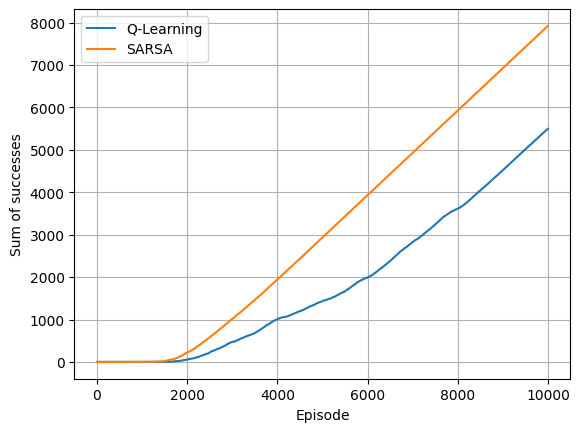

In [61]:
plt.plot(q_learning_list, label='Q-Learning')
plt.plot(sarsa_list, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Sum of successes')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.plot(epsilon_hystory, label='epsilon')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Epsilon decay')
plt.legend()
plt.grid(True)
plt.show()